In [1]:
import numpy as np
import pandas as pd
import os
from DS_models_stat import cut_cat
from DS_Planck_Unet import val_pix, west_val, east_val
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
det_cat = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv')
true_cat = pd.read_csv('/home/rt2122/Data/SRGz/clusters/clusters1_east_val_edit.csv')
true_cat = true_cat.rename(columns={'flux_05-20' : 'flux'})

In [3]:
def match_prm(det_cat, true_cat, match_dist=5/60, prms=[]):
    det_sc = SkyCoord(ra=np.array(det_cat['RA'])*u.degree, dec=np.array(det_cat['DEC'])*u.degree, frame='icrs')
    true_sc = SkyCoord(ra=np.array(true_cat['RA'])*u.degree, dec=np.array(true_cat['DEC'])*u.degree, frame='icrs')
    
    idx, d2d, _ = det_sc.match_to_catalog_sky(true_sc)
    matched = d2d.degree < match_dist
    det_cat['found'] = False
    det_cat.loc[matched, 'found'] = True
    det_cat['tRA'] = np.nan
    det_cat['tDEC'] = np.nan
    true_cat = true_cat.rename(columns={'RA' : 'tRA', 'DEC' : 'tDEC'})
    
    for prm in prms + ['tRA', 'tDEC']:
        det_cat[prm] = 0
        det_cat[prm].iloc[matched] = np.array(true_cat[prm].iloc[idx[matched]])
    return det_cat

In [4]:
det_cat = match_prm(det_cat, true_cat, match_dist=400/3600, prms=['flux'])

/home/rt2122/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
det_cat = det_cat[det_cat['found']]
det_cat.index = np.arange(len(det_cat))

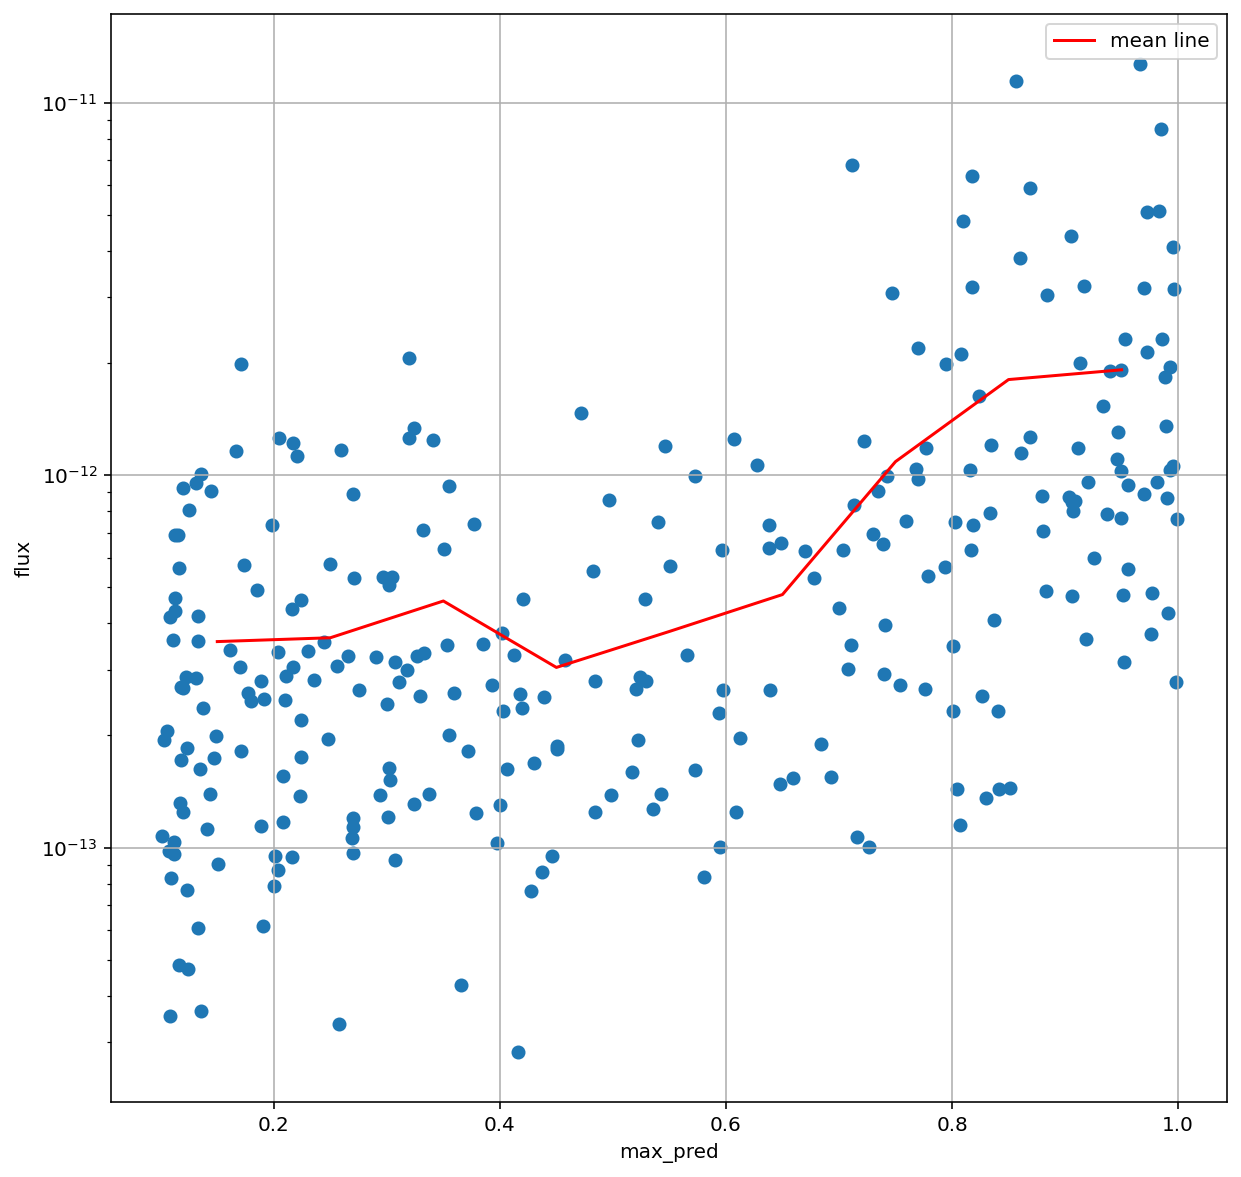

In [22]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(det_cat['max_pred'], det_cat['flux'])
l, = ax.plot(mean_max_pred, mean_flux, c='r')
l.set_label('mean line')
ax.set_xlabel('max_pred')
ax.set_ylabel('flux')
ax.legend()
ax.grid()
plt.yscale('log')
plt.show()

In [20]:
max_pred_prm = np.arange(0, 1.1, 0.1)
mean_max_pred = (max_pred_prm[:-1] + max_pred_prm[1:])/2
mean_max_pred

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [21]:
mean_flux = []
for i in range(len(max_pred_prm) - 1):
    st = max_pred_prm[i]
    en = max_pred_prm[i + 1]
    matched = np.logical_and( st<= det_cat['max_pred'], det_cat['max_pred'] < en)
    mean_flux.append(det_cat['flux'][matched].mean())
    